# Image postprocessing of PMDI sprays

This program takes images of PMDI sprays and obtains extinction profiles.
    
    @author Daniel Duke <daniel.duke@monash.edu>
    @copyright (c) 2020 LTRAC
    @license GPL-3.0+
    @version 0.0.1
    @date 07/05/2020
        __   ____________    ___    ______
       / /  /_  ____ __  \  /   |  / ____/
      / /    / /   / /_/ / / /| | / /
     / /___ / /   / _, _/ / ___ |/ /_________
    /_____//_/   /_/ |__\/_/  |_|\__________/

    Laboratory for Turbulence Research in Aerospace & Combustion (LTRAC)
    Monash University, Australia



In [1]:
from pySciCam.pySciCam import ImageSequence # https://github.com/djorlando24/pySciCam
import numpy as np
import glob, sys, os
import matplotlib.pyplot as plt
from scipy.interpolate import interp2d
import scipy.integrate
%matplotlib notebook


In [2]:
# Define where images come from.
source_images = "/Users/dduke/Desktop/ThinBo-1Hole-E05 Example Series"
source_bkgnd = "/Users/dduke/Desktop/ThinBo-1Hole-E05 Example Series/bkgnd.tif"


In [3]:
# Read in images.
B=ImageSequence(source_bkgnd)
I=ImageSequence("/Users/dduke/Desktop/ThinBo-1Hole-E05 Example Series/", IO_threads=4)

# apply crop
B.crop(107,107+304,85,85+915)
I.crop(107,107+304,85,85+915)
print('\nFinal array sizes:', B.shape(), I.shape())

# Mask unwanted portions of image
B.mask_box(268,305,903,916)
B.mask_box(0,42,903,916)

# apply flip
B.fliph()
I.fliph()


Reading /Users/dduke/Desktop/ThinBo-1Hole-E05 Example Series/bkgnd.tif
PythonMagick library is not installed.
Falling back to Pillow (fewer file formats supported)
	PIL thinks the bit depth is >u2
	Increasing stored bit depth from >u2 to >u2
	Reading files into memory...
Read 1.0 MiB in 0.0 sec
	Data in memory:	 (1, 512, 1024)
	Intensity range:	 0 to 39238 	 >u2
	Array size:	-0.5 MB
Reading /Users/dduke/Desktop/ThinBo-1Hole-E05 Example Series/
	Found 801 images with extension .tif
PythonMagick library is not installed.
Falling back to Pillow (fewer file formats supported)
	PIL thinks the bit depth is >u2
	Increasing stored bit depth from >u2 to >u2
	Reading files into memory...
40 tasks on 4 processors


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    1.8s
[Parallel(n_jobs=4)]: Done  41 out of  41 | elapsed:    6.0s finished


Read 801.0 MiB in 6.8 sec
	Data in memory:	 (801, 512, 1024)
	Intensity range:	 0 to 39781 	 uint16
	Array size:	801.0 MB

Final array sizes: (1, 305, 916) (801, 305, 916)


In [5]:
# Remove background, put into array Ib
Ib = np.zeros_like(I.arr,dtype=np.float32)
bkgnd = B.arr[0,...].astype(np.float32)
bkgnd[bkgnd<=0] = np.nan
for n in range(I.N):
    Ib[n,...] = I.arr[n,...] / bkgnd
    
# Convert transmission to extinction
Ib = 1.0 - Ib

# Get co-ordinates
y = np.arange(Ib.shape[1])
x = np.arange(Ib.shape[2])
t = np.arange(Ib.shape[0])


<IPython.core.display.Javascript object>


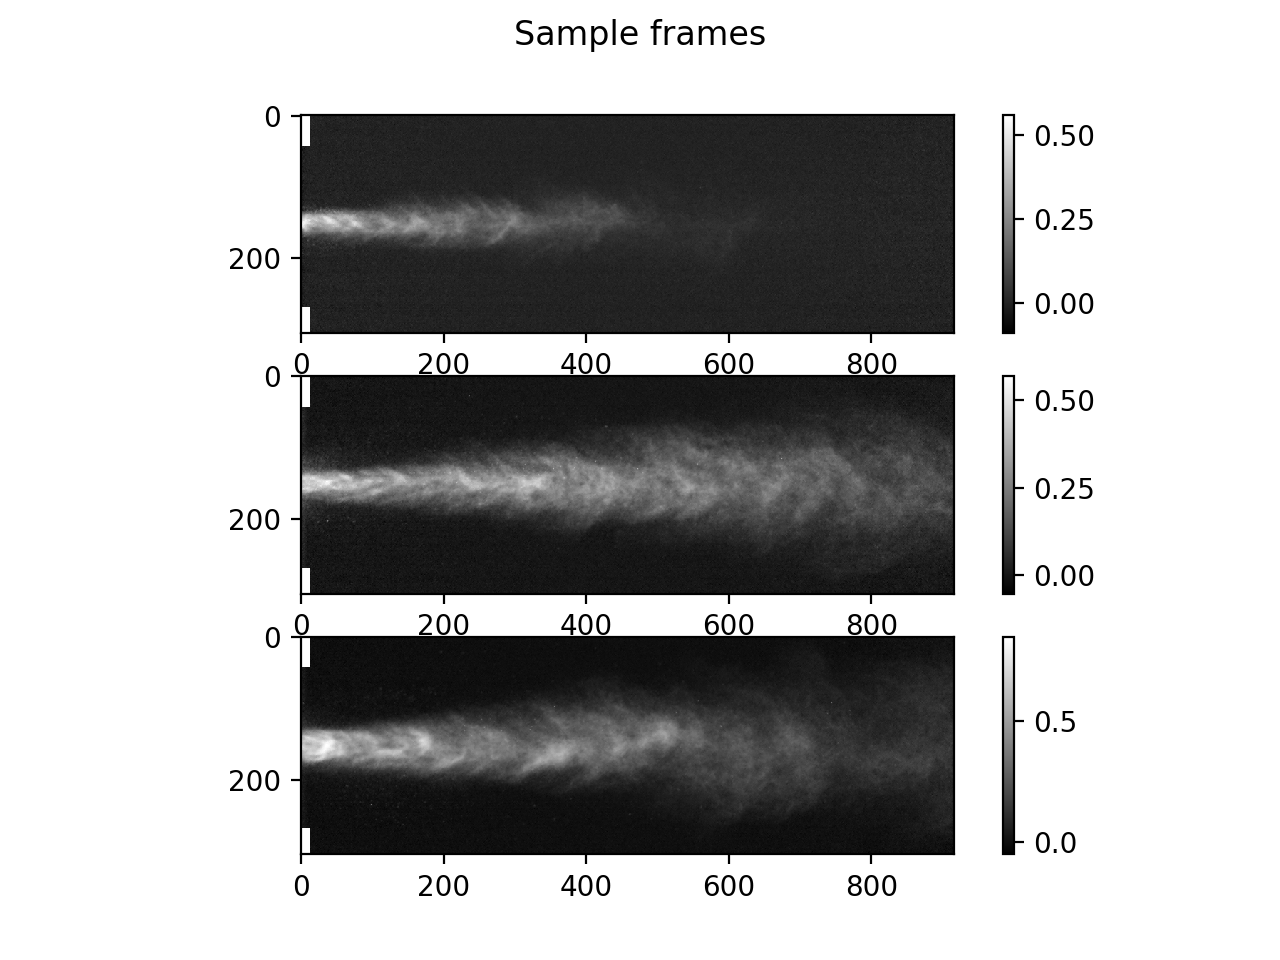

In [6]:
# Show some samples
fig=plt.figure()
plt.suptitle("Sample frames")
ax=fig.add_subplot(311)
h=ax.imshow(Ib[38,...],cmap=plt.cm.gray)
plt.colorbar(h)
ax=fig.add_subplot(312)
h=ax.imshow(Ib[50,...],cmap=plt.cm.gray)
plt.colorbar(h)
ax=fig.add_subplot(313)
h=ax.imshow(Ib[75,...],cmap=plt.cm.gray)
plt.colorbar(h);


In [60]:
# Reslice near the nozzle to see time evolution
# Average over several X positions.
near_nozzle_profiles = np.nanmean(Ib[...,10:25],axis=-1).T
near_nozzle_integral = scipy.integrate.simps(near_nozzle_profiles.T,x=y,axis=-1)

# Use the integral to find the spray "on" time
threshold = 0.67 # higher value means less time samples but lower std dev.
on = np.where(near_nozzle_integral > threshold*np.nanmax(near_nozzle_integral))[0]
t0,t1 = on[0],on[-1]


<IPython.core.display.Javascript object>


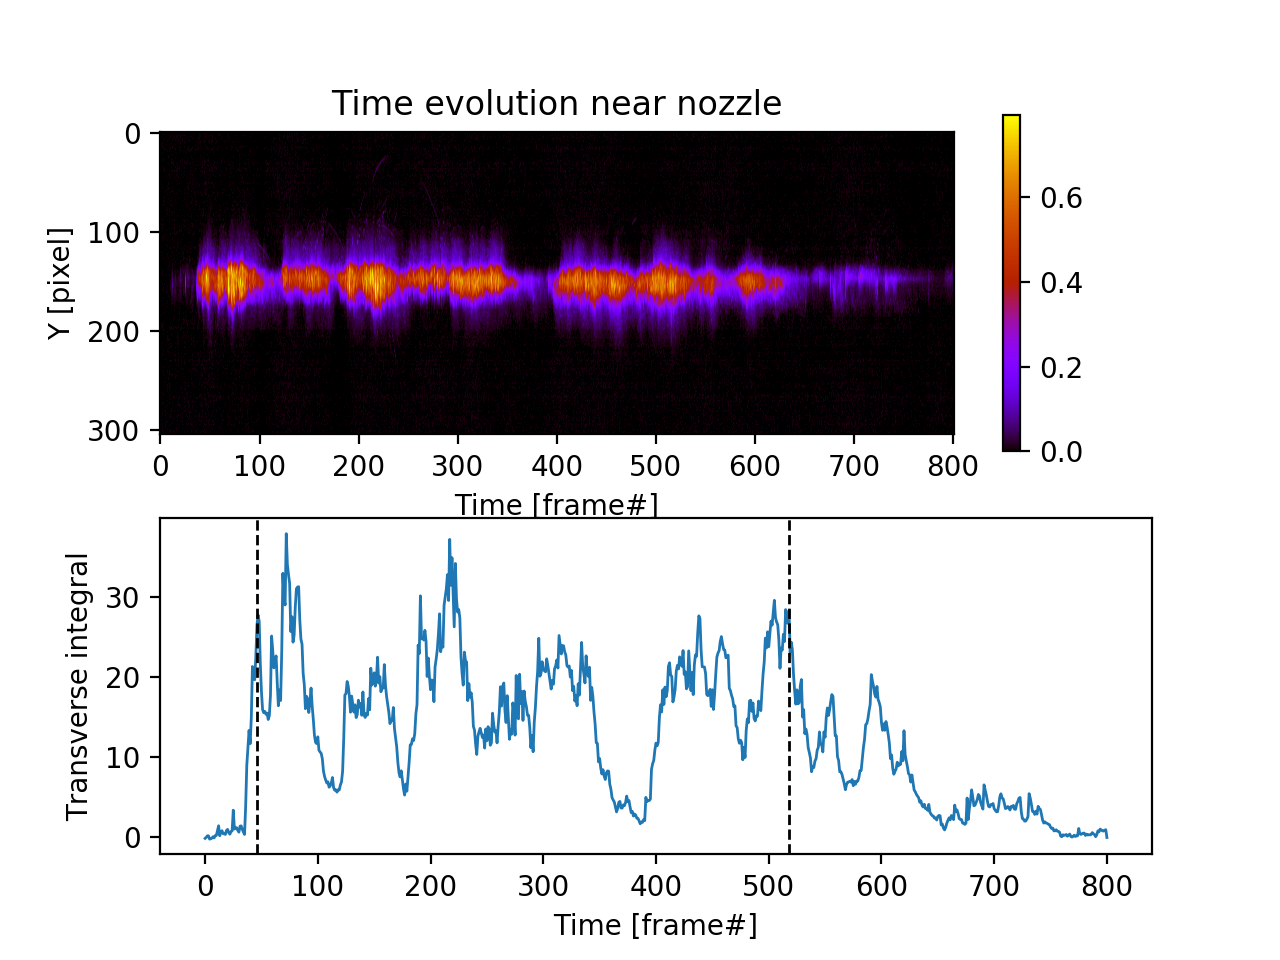

In [61]:
# Show the time evolution near the nozzle
fig=plt.figure()
ax=fig.add_subplot(211)
plt.title("Time evolution near nozzle")
plt.ylabel("Y [pixel]")
plt.xlabel("Time [frame#]")
h=ax.imshow(near_nozzle_profiles, cmap=plt.cm.gnuplot,vmin=0)
plt.colorbar(h);
ax=fig.add_subplot(212)
ax.plot(t, near_nozzle_integral, lw=1)
plt.axvline(t0,c='k',lw=1,ls='--')
plt.axvline(t1,c='k',lw=1,ls='--')
plt.ylabel("Transverse integral")
plt.xlabel("Time [frame#]");


In [62]:
# Take mean & std dev over "steady state" period
Im = np.nanmean(Ib[t0:t1+1],axis=0)
Is = np.nanstd(Ib[t0:t1+1],axis=0)
print("averaging over %i frames in time" % (t1-t0+1))


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  


averaging over 473 frames in time


In [63]:
# Find spray centerline evaluated at two x locations with straight line
xr = 10; xl = 200
yr = np.where(Im[:,xr] == np.nanmax(Im[:,xr]))[0][0] # use max for extinction, min for transmission...
yl = np.where(Im[:,xl] == np.nanmax(Im[:,xl]))[0][0]
centerline = lambda x: x*(yl-yr)/float(xl-xr) + (yl - xl*(yl-yr)/float(xl-xr))

# Get mean and std profile interpolated along the centerline
Fint = interp2d(x,y,np.nan_to_num(Im))
mean_centerline_profile = np.array([ Fint(x_,centerline(x_)) for x_ in x ]).flatten()
Fint = interp2d(x,y,np.nan_to_num(Is))
std_centerline_profile = np.array([ Fint(x_,centerline(x_)) for x_ in x ]).flatten()

# Apply a bit of smoothing to the profiles
wl=10 # pixels
window = np.hanning(wl)
window /= scipy.integrate.simps(window)
mean_centerline_profile = np.convolve(mean_centerline_profile, window, 'same')
std_centerline_profile = np.convolve(std_centerline_profile, window, 'same')


<IPython.core.display.Javascript object>


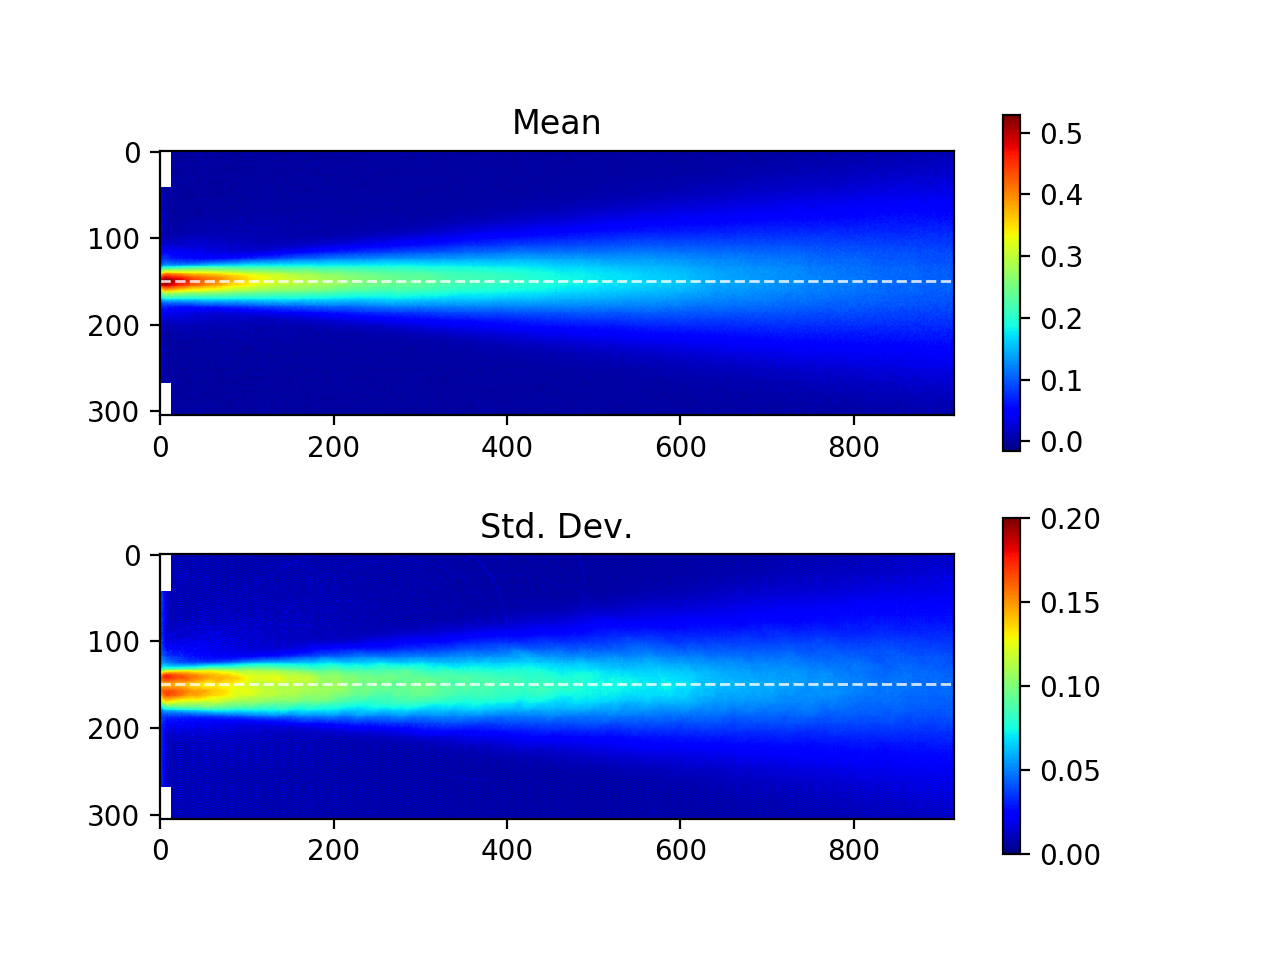

In [64]:
# Plot mean and std dev profiles
fig=plt.figure()
ax=fig.add_subplot(211)
plt.title("Mean")
h=ax.imshow(Im,cmap=plt.cm.jet)
ax.plot(x, centerline(x), c='w', lw=1, ls='--', alpha=.8)
plt.colorbar(h)

ax=fig.add_subplot(212)
plt.title("Std. Dev.")
h=ax.imshow(Is,cmap=plt.cm.jet,vmin=0,vmax=0.2)
ax.plot(x, centerline(x), c='w', lw=1, ls='--', alpha=.8)
plt.colorbar(h);


<IPython.core.display.Javascript object>


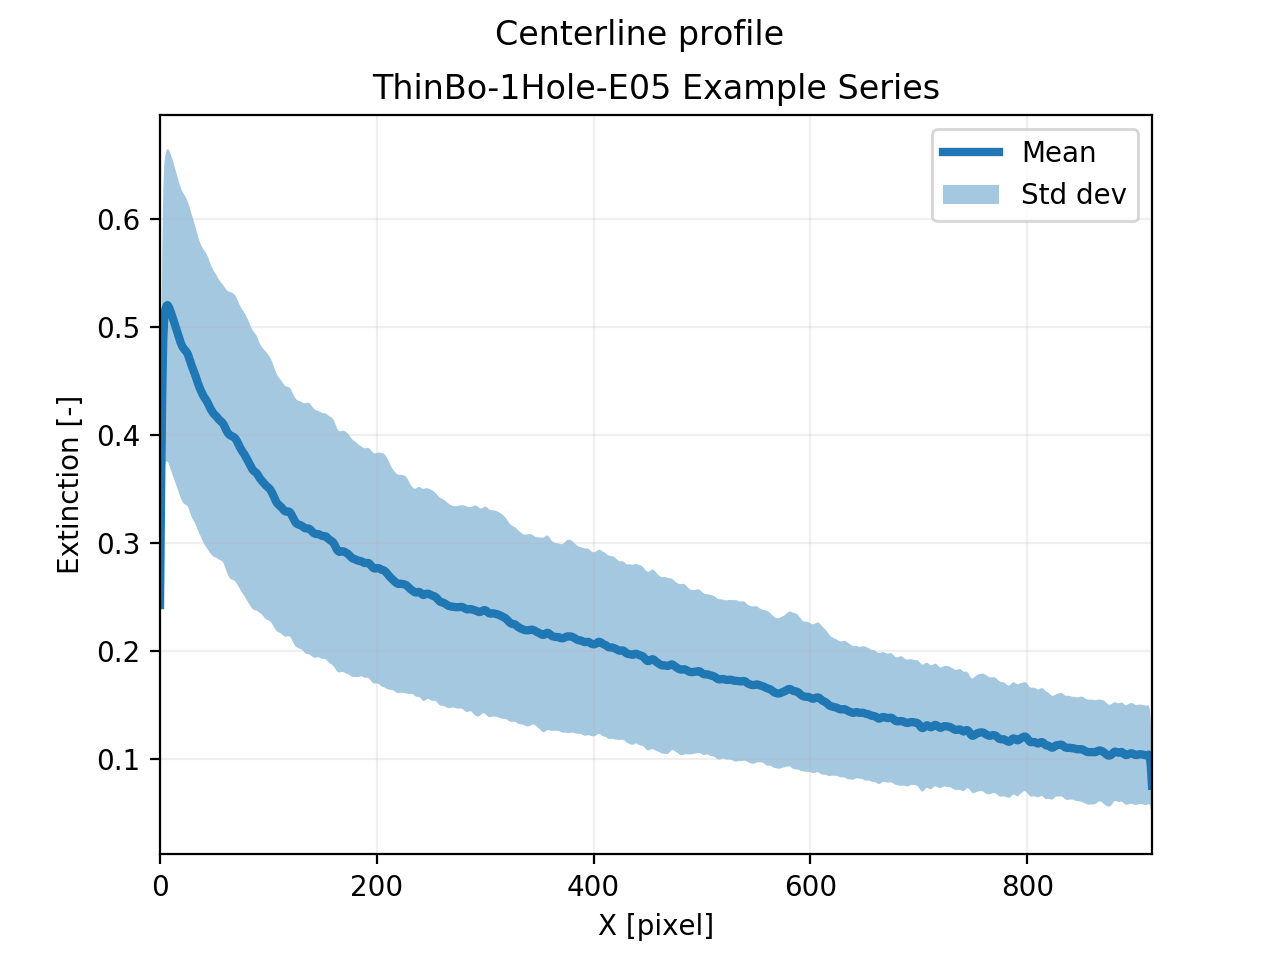

In [65]:
# Plot centerline profiles
fig=plt.figure()
ax=fig.add_subplot(111)
plt.grid(alpha=.2)
plt.suptitle("Centerline profile")
plt.title(os.path.basename(source_images))
plt.ylabel("Extinction [-]")
plt.xlabel("X [pixel]")
ax.plot(x,mean_centerline_profile,label='Mean',lw=3)
ax.fill_between(x,mean_centerline_profile-std_centerline_profile,\
                  mean_centerline_profile+std_centerline_profile,\
                  alpha=.4,label='Std dev')
plt.xlim(0,x.max())
plt.legend();
